# Preliminary Exploration Notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

First, we load the data, which is split between two files. The first one is the actual data samples, and the second is a frame specificying additional details and descriptions about the data

In [3]:
school_data = pd.read_csv("data/CRDC 2015-16 School Data.csv", encoding = "ISO-8859-1")
school_layout = pd.read_csv("data/CRDC 2015-16 School Data Record Layout.csv", encoding = "ISO-8859-1")

/Users/dieterbrehm/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,6,23,24,25,30,31,1828) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The need for the second frame becomes more obvious when we look at both the naming style of the main data columns and the sheer number of the columns.

In [4]:
school_data.head()

,LEA_STATE,LEA_STATE_NAME,LEAID,LEA_NAME,SCHID,SCH_NAME,COMBOKEY,JJ,SCH_GRADE_PS,SCH_GRADE_KG,...,SCH_FTESERVICES_PSY,SCH_FTESERVICES_SOC,SCH_JJTYPE,SCH_JJSYDAYS,SCH_JJHOURS,SCH_JJPART_LT15,SCH_JJPART_15T30,SCH_JJPART_31T90,SCH_JJPART_91T180,SCH_JJPART_OV180
0,AL,ALABAMA,100002,Alabama Youth Services,1705,Wallace Sch - Mt Meigs Campus,10000201705,Yes,No,No,...,2.0,0.0,-7,-7,-7,-7,-7,-7,-7,-7
1,AL,ALABAMA,100002,Alabama Youth Services,1706,McNeel Sch - Vacca Campus,10000201706,Yes,No,No,...,1.0,0.0,-7,-7,-7,-7,-7,-7,-7,-7
2,AL,ALABAMA,100002,Alabama Youth Services,1876,Alabama Youth Services,10000201876,No,No,No,...,0.0,0.0,-9,-9,-9,-9,-9,-9,-9,-9
3,AL,ALABAMA,100002,Alabama Youth Services,99995,AUTAUGA CAMPUS,10000299995,Yes,No,No,...,0.0,0.0,-7,-7,-7,-7,-7,-7,-7,-7
4,AL,ALABAMA,100005,Albertville City,870,Albertville Middle School,10000500870,No,No,No,...,0.0,0.0,-9,-9,-9,-9,-9,-9,-9,-9


In fact, we have 1836 columns of data to deal with! Some of it is very rich with information and dense, while other parts of it are incomplete or sparse.

In [5]:
school_data.shape

(96360, 1836)

This is a function for linking a column code (in the main frame) and a additional description in the layout frame 

In [6]:
def describe_column(column_code):
    pd.set_option('display.max_colwidth', -1)
    desc = school_layout[school_layout["Field_Name"] == column_code]["Field_Description"].to_string()
    return desc

describe_column("SCH_JJHOURS")

'1830    Justice Facility Educational Program Hours per Week'

A few interesting data features we need to consider:

**Note:**  For cell values in the school data frame, negative numbers have special meanings as follows:  
-2 means small cell values,  
-5 means there is an action plan (next survey),  
-6 Force Certified (missing data),  
-7 System error,  
-8 EDFacts Missing Data,  
-9 means not applicable / skipped

Then, let's look at the percent of each column which doesn't contain quantitative data.

In [7]:
# print(len(school_data[school_data["LEA_STATE_NAME"] == "CALIFORNIA"]))
nul_vals = [-2,-5,-6,-7,-8,-9, '-2', '-5', '-6','-7','-8','-9']
rates = []
rates_full = []
for (columnName, columnData) in school_data.iteritems():
    error_rate = round(len(school_data[columnName][school_data[columnName].isin(nul_vals)])/school_data.shape[0], 3)
    column_name = columnName
    rates.append(error_rate)
    rates_full.append([error_rate, column_name])
#     print(error_rate, column_name)

Heres a visualization of the usable portions of the data in terms of the percent present in the frame versus the length of the frame. Documentation in the dataset provided codes for what values are to be considered not present (missing data, have future plan for data)

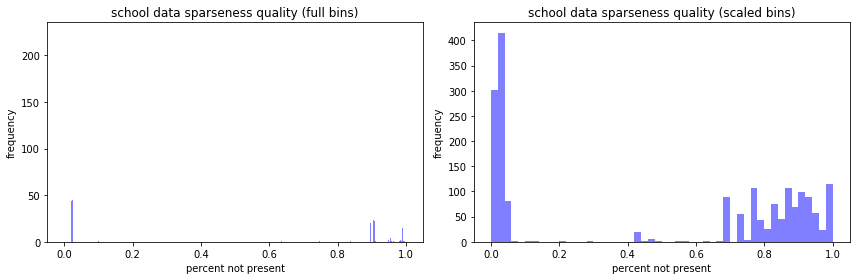

In [8]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))
ax0.hist(rates, len(rates), facecolor='blue', alpha=0.5)
ax0.set_xlabel("percent not present")
ax0.set_ylabel("frequency")
ax0.set_title("school data sparseness quality (full bins)")

ax1.hist(rates, 50, facecolor='blue', alpha=0.5)
ax1.set_xlabel("percent not present")
ax1.set_ylabel("frequency")
ax1.set_title("school data sparseness quality (scaled bins)")

fig.tight_layout()
plt.show()

For a particular column, let's look at all of the unique values present (types of data). This is an example in the data set of a column whose data would need to be replaced with dummy variables before any modeling could occur.


In [26]:
column = "SCH_ALGENR_GS1112_HI_M"
print(describe_column("SCH_ALGENR_GS1112_HI_M")) # description of the data
print(school_data[column].unique()) # types of values present in the dataset
print(school_data[column][~school_data[column].isin(nul_vals)]) # non null data preview

238    Student Enrollment in Algebra I (Grades 11-12): Hispanic Male
[  0  -9   5   2   8  14  11  17  20  35  23  38  41  80  47  26  59  53
  29  68 128 143 161 158 167  83 101 110  32  74  77  44  56 125  50 116
  65 107  71  89 134 206 182 239 212  62  92 209 278 215  86 122 173  95
 137 140 269 227 104 146  -5 302]
0        0
1        0
2        0
3        0
5        5
        ..
96355    0
96356    0
96357    2
96358    0
96359    0
Name: SCH_ALGENR_GS1112_HI_M, Length: 21961, dtype: int64


We have a few ranges of columns which we are interested in, specifically ones which in a rough way estimate the "success" of a school (which is a single row in our dataset). Before we can do much modeling on it, we need to look at the datatypes and which unique values are present in each column

In [29]:
ap_data = school_data.iloc[: , 492:657]
sat_data = school_data.iloc[: , 679:698]
math_data = school_data.iloc[: , 194:319]

Print out the datatypes of the dataframes

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(ap_data.dtypes)
#     print(sat_data.dtypes)
    print(math_data.dtypes)

SCH_ALGENR_G07               int64 
SCH_ALGENR_G08_IND           object
SCH_ALGENR_G08_HI_M          int64 
SCH_ALGENR_G08_HI_F          int64 
SCH_ALGENR_G08_AM_M          int64 
SCH_ALGENR_G08_AM_F          int64 
SCH_ALGENR_G08_AS_M          int64 
SCH_ALGENR_G08_AS_F          int64 
SCH_ALGENR_G08_HP_M          int64 
SCH_ALGENR_G08_HP_F          int64 
SCH_ALGENR_G08_BL_M          int64 
SCH_ALGENR_G08_BL_F          int64 
SCH_ALGENR_G08_WH_M          int64 
SCH_ALGENR_G08_WH_F          int64 
SCH_ALGENR_G08_TR_M          int64 
SCH_ALGENR_G08_TR_F          int64 
TOT_ALGENR_G08_M             int64 
TOT_ALGENR_G08_F             int64 
SCH_ALGENR_G08_LEP_M         int64 
SCH_ALGENR_G08_LEP_F         int64 
SCH_ALGENR_G08_IDEA_M        int64 
SCH_ALGENR_G08_IDEA_F        int64 
SCH_MATHCLASSES_ALG          int64 
SCH_MATHCERT_ALG             int64 
SCH_ALGENR_GS0910_HI_M       int64 
SCH_ALGENR_GS0910_HI_F       int64 
SCH_ALGENR_GS0910_AM_M       int64 
SCH_ALGENR_GS0910_AM_F      

Skipping back a bit, lets sort the columns by presence, to see which columns predominantly have non-null values.

In [12]:
# sorted(rates_full, key = lambda x: x[0])

In [33]:
describe_column("TOT_ALGPASS_GS1112_M")

'313    Students who passed Algebra I (Grades 11-12 or UG High School Age): Calculated Male Total'

In [36]:
column = "SCH_MATHENR_GEOM_AS_F"
print(describe_column("SCH_MATHENR_GEOM_AS_F")) # description of the data
print(school_data[column].unique()) # types of values present in the dataset
print(school_data[column][~school_data[column].isin(nul_vals)]) # non null data preview
# print(len(school_data[school_data["LEA_STATE_NAME"] == "CALIFORNIA"]))
nul_vals = [-2,-5,-6,-7,-8,-9, '-2', '-5', '-6','-7','-8','-9']
rates = []
rates_full = []
columnName = "SCH_MATHENR_GEOM_AS_F"
columnData = school_data["SCH_MATHENR_GEOM_AS_F"]
error_rate = round(len(school_data[columnName][school_data[columnName].isin(nul_vals)])/school_data.shape[0], 3)
column_name = columnName
rates.append(error_rate)
rates_full.append([error_rate, column_name])
print(error_rate, column_name)

328    Student Enrollment in Geometry: Asian Female
[  0  -9   2  26  14   5   8  35  11  32  20  68  23  17  41  50  53  29
 137 206 149  38 170  59  56  47 182  77  62  86  71 101  74  65 119 146
 155 128  95  92 140  80 179  44  89 110 131 104  98 209 164 122  83 230
 152 116  -5 134 167 113 200 188 203 347 158 224 260 107]
0        0
1        0
2        0
5        0
11       0
        ..
96349    0
96356    0
96357    0
96358    0
96359    0
Name: SCH_MATHENR_GEOM_AS_F, Length: 22210, dtype: int64
0.77 SCH_MATHENR_GEOM_AS_F
